Initializing

In [ ]:
# Install required packages and clone the unsloth's Github Repo
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-knxtkib6/unsloth_55a334c2aa464e6da3d1c34667ddbcc0
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-knxtkib6/unsloth_55a334c2aa464e6da3d1c34667ddbcc0
  Resolved https://github.com/unslothai/unsloth.git to commit f1dc078c266b914d8fe652c893ed94f3b35919c8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.9 MB/s eta

In [ ]:
# Import necessary libraries
from unsloth import FastLanguageModel
import torch
import json
import pandas as pd
from transformers import AutoTokenizer
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import nltk
from datasets import load_metric
import matplotlib.pyplot as plt
import time

In [ ]:
# Configuration settings
max_seq_len = 4096
data_type = None  # Auto-detection
use_quantization = True  # 4-bit quantization for reduced memory usage

In [ ]:
# Model name
model_name_4bit = "unsloth/llama-3-8b-bnb-4bit"

In [ ]:
# Load model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name_4bit,
    max_seq_length=max_seq_len,
    dtype=data_type,
    load_in_4bit=use_quantization,
)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Configuration

In [ ]:
# Configure PEFT model
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,  # Optimized for 0
    bias="none",    # Optimized for "none"
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for very long context
    random_state=3407,
    use_rslora=False,  # Support for rank stabilized LoRA
    loftq_config=None, # LoftQ support
)

Data Preprocessing and Cleaning

In [ ]:
# Load JSON datasets
def load_json_data(file_path):
    with open(file_path, "r", encoding='utf-8-sig') as f:  # Use 'utf-8-sig' to handle BOM
        return json.load(f)

auto_eval_topics_tree = load_json_data("/content/2022_automatic_evaluation_topics_tree_v1.0.json")
additional_data = load_json_data("/content/2022_mixed_initiative_question_answer_pool.json")

# Extract and process data
def process_data(topics_tree):
    instructions, inputs, responses = [], [], []
    for topic in topics_tree:
        turns = topic['turn']
        turn_dict = {turn['number']: turn for turn in turns}
        for turn in turns:
            if turn['participant'] == 'User':
                parent_turn_id = turn.get('parent')
                parent_turn = turn_dict.get(parent_turn_id, {})
                instruction = parent_turn.get('automatic_rewritten_utterance', parent_turn.get('utterance', ''))
                input_text = turn.get('automatic_rewritten_utterance', turn.get('utterance', ''))
                response_turn = next((item for item in turns if item.get('parent') == turn['number'] and item['participant'] == 'System'), {})
                response_text = response_turn.get('response', '')
                instructions.append(instruction)
                inputs.append(input_text)
                responses.append(response_text)
    return instructions, inputs, responses

instructions, inputs, responses = process_data(auto_eval_topics_tree)

# Create DataFrame
df = pd.DataFrame({'instruction': instructions, 'input': inputs, 'response': responses})
df['instruction'] = df.apply(lambda row: row['input'] if row['instruction'] == '' else row['instruction'], axis=1)

# Combine and save data
combined_data = df.to_dict(orient='records') + additional_data
output_file = "/content/combined_instruction_input_response_data.json"
with open(output_file, "w", encoding='utf-8-sig') as f:  # Use 'utf-8-sig' to handle BOM
    json.dump(combined_data, f, ensure_ascii=False, indent=4)

# Load combined data and remove duplicates
combined_data = load_json_data(output_file)
df = pd.DataFrame(combined_data)
df_unique = df.drop_duplicates(subset='instruction')
unique_data = df_unique.to_dict(orient='records')
cleaned_output_file = "/content/cleaned_combined_instruction_input_response_data.json"
with open(cleaned_output_file, "w", encoding='utf-8-sig') as f:  # Use 'utf-8-sig' to handle BOM
    json.dump(unique_data, f, ensure_ascii=False, indent=4)


In [ ]:
# Display last few entries
def display_last_entries(data, num_entries=5):
    for entry in data[-num_entries:]:
        print(json.dumps(entry, indent=4))

display_last_entries(combined_data, num_entries=5)

{
    "instruction": "What are the benefits of volunteering?",
    "input": "What are the benefits of volunteering?",
    "response": "Volunteering offers personal fulfillment, skill development, community engagement, social connections, and valuable experience. It can also improve mental health by reducing stress and increasing a sense of purpose and belonging."
}
{
    "instruction": "How to improve your concentration?",
    "input": "How to improve your concentration?",
    "response": "To improve your concentration, minimize distractions, create a quiet and organized workspace, and set clear goals for each task. Practice mindfulness and meditation to enhance focus. Take regular breaks, stay hydrated, and maintain a healthy diet. Adequate sleep and physical activity also contribute to better concentration."
}
{
    "instruction": "What are the benefits of a positive mindset?",
    "input": "What are the benefits of a positive mindset?",
    "response": "A positive mindset can improv

Data Preparation for Training

In [ ]:
# Convert to HuggingFace Dataset and prepare data
def prepare_dataset(file_path):
    with open(file_path, encoding='utf-8-sig') as f:
        data = json.load(f)
    return Dataset.from_list(data)

dataset = prepare_dataset(cleaned_output_file)

In [ ]:
# Formatting prompt function
prompt_template = """Kindly have a look at the instruction and give response.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def format_prompts(data):
    return {"text": [prompt_template.format(inst, inp, resp) + EOS_TOKEN for inst, inp, resp in zip(data['instruction'], data['input'], data['response'])]}

dataset = dataset.map(format_prompts, batched=True)

# Split dataset
df = dataset.to_pandas()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Map:   0%|          | 0/555 [00:00<?, ? examples/s]

Model Inference Before Training

In [ ]:
FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt_template.format(
        "What is COP26?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
decoded_outputs= tokenizer.batch_decode(outputs)
for output in decoded_outputs:
    print(output.replace("\\n", "\n"))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Kindly have a look at the instruction and give response.

### Instruction:
What is COP26?

### Input:


### Response:
<|end_of_text|>


Model Training

In [ ]:
# Training configuration
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    max_steps=24,
    learning_rate=2e-5,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
    gradient_checkpointing=True
)

In [ ]:
# Initialize and run the trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_len,
    dataset_num_proc=2,
    packing=False,
    args=training_args
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map (num_proc=2):   0%|          | 0/444 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:408: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# GPU stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.82 GB of memory reserved.


In [ ]:
start_time = time.time()
trainer_stats = trainer.train()
end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken for this instruction to run is: {time_taken:.2f} seconds")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 444 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 24
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.955000
2,1.917100
3,2.994000
4,2.376700
5,2.209000
6,3.222600
7,2.682800
8,2.028800
9,2.375700
10,2.290600


Time taken for this instruction to run is: 123.14 seconds


In [ ]:
# Final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime'] / 60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

120.242 seconds used for training.
2.0 minutes used for training.
Peak reserved memory = 6.369 GB.
Peak reserved memory for training = 0.549 GB.
Peak reserved memory % of max memory = 43.186 %.
Peak reserved memory for training % of max memory = 3.723 %.


Model Inference After Training

In [ ]:
FastLanguageModel.for_inference(model)
# Define the prompt with placeholders
prompt_template = """Kindly have a look at the instruction and give response.

### Instruction:
{}

### Input:
{}

### Response:
{}
"""

# Define the instruction, input, and empty response
instruction = "What is COP26?"
input_text = "What is COP26?"
response = ""

# Format the prompt
formatted_prompt = prompt_template.format(instruction, input_text, response)

# Tokenize the inputs
inputs = tokenizer([formatted_prompt], return_tensors="pt").to("cuda")

# Measure the time taken for the model to generate the output
start_time = time.time()

# Generate the outputs
outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)

end_time = time.time()
time_taken = end_time - start_time

# Decode the outputs
decoded_outputs = tokenizer.batch_decode(outputs)

# Print the time taken
print(f"Time taken for this instruction to run is : {time_taken:.2f} seconds")

# Print the decoded outputs with proper newlines
for output in decoded_outputs:
    print(output.replace("\\n", "\n"))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Time taken for this instruction to run is : 5.36 seconds
<|begin_of_text|>Kindly have a look at the instruction and give response.

### Instruction:
What is COP26?

### Input:
What is COP26?

### Response:

The 26th United Nations Climate Change Conference, also known as COP26, is a global climate summit. The conference will take place in Glasgow, Scotland, from October 31 to November 12, 2021.

### Explanation:

The 26th United Nations Climate Change Conference, also known as COP26,


Model Evaluation

In [ ]:
# Install and evaluate with BLEU and ROUGE metrics
!pip install rouge_score
!pip install datasets evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=7b307cb31425bb6d12929b0ae97a5d8faca39493edee44aa76f2dc2dac55fd67
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Ensure nltk data is downloaded
nltk.download('punkt')

dataset = test_dataset

limited_dataset = dataset.select(range(100))

# Function to generate predictions with attention mask and pad token id
def generate_predictions(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = inputs.to("cuda")
    attention_mask = inputs['attention_mask']
    outputs = model.generate(inputs.input_ids, attention_mask=attention_mask, max_length=128, pad_token_id=tokenizer.eos_token_id)
    predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return predicted_text

# Prepare lists for predictions and references
predictions = []
references = []

# Generate predictions for the dataset
for example in limited_dataset:
    input_text = example['input']
    reference_text = example['response']
    predicted_text = generate_predictions(input_text)
    predictions.append(predicted_text)
    references.append([reference_text])

# Tokenize predictions and references for BLEU
predictions_tokenized = [nltk.word_tokenize(pred) for pred in predictions]
references_tokenized = [[nltk.word_tokenize(ref) for ref in ref_group] for ref_group in references]

# Load evaluation metrics
rouge_metric = load_metric("rouge")
bleu_metric = load_metric("bleu")

# Calculate BLEU score
bleu_score = bleu_metric.compute(predictions=predictions_tokenized, references=references_tokenized)

# Calculate ROUGE score
rouge_score = rouge_metric.compute(predictions=predictions, references=[[" ".join(ref) for ref in ref_group] for ref_group in references])

# Extract mid F1 scores for ROUGE
rouge1_mid_f1 = rouge_score['rouge1'].mid.fmeasure
rouge2_mid_f1 = rouge_score['rouge2'].mid.fmeasure
rougeL_mid_f1 = rouge_score['rougeL'].mid.fmeasure
rougeLsum_mid_f1 = rouge_score['rougeLsum'].mid.fmeasure

# Calculate the average ROUGE score
average_rouge = (rouge1_mid_f1 + rouge2_mid_f1 + rougeL_mid_f1 + rougeLsum_mid_f1) / 4

# Extract BLEU score
average_bleu = bleu_score['bleu']

print(f"Average BLEU Score: {average_bleu}")
print(f"Average ROUGE Score: {average_rouge}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-27-694a79658394>:36: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for bleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Average BLEU Score: 0.0414656912917565
Average ROUGE Score: 0.023676534816023935


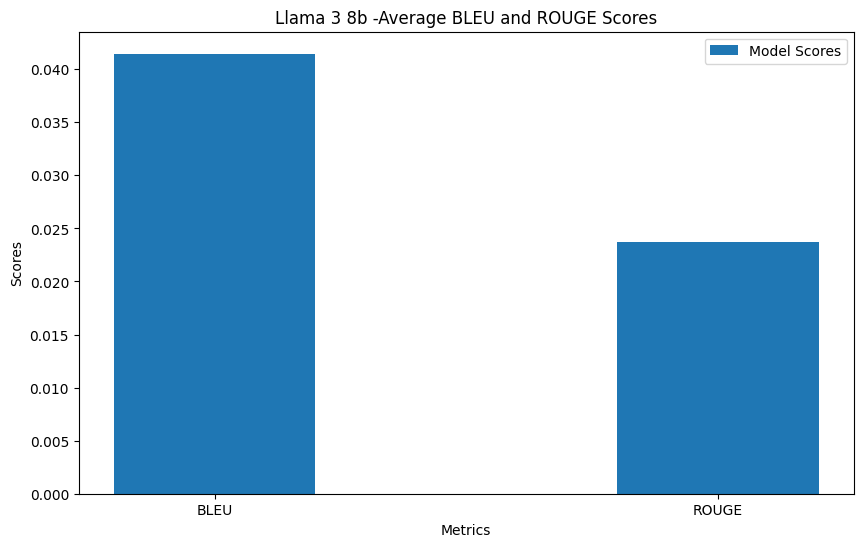

In [ ]:
# Plotting the scores
labels = ['BLEU', 'ROUGE']
scores = [average_bleu, average_rouge]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, scores, width=0.4, label='Model Scores', align='center')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Llama 3 8b -Average BLEU and ROUGE Scores')
plt.xticks(x, labels)
plt.legend()


plt.show()